In [1]:
from pydantic import BaseModel
from typing import Optional, Literal

In [2]:
class PortfolioState(BaseModel):
    amount_in_usd: Optional[float] = 0
    total_usd: Optional[float] = 0
    target_currency: Literal["INR", "EUR"]
    target_currency_amount: Optional[float] = 0

In [20]:
def calculate_total_usd(state: PortfolioState) -> PortfolioState:
    state.total_usd = round(state.amount_in_usd * 1.08, 2)
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state.target_currency_amount = round(state.total_usd * 85, 2)
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state.target_currency_amount = round(state.total_usd * 0.85, 2)
    return state

def choose_target_currency(state: PortfolioState) -> str:
    return state.target_currency

In [21]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calculate_total_usd_node", calculate_total_usd)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calculate_total_usd_node")
builder.add_conditional_edges(
    "calculate_total_usd_node", 
    choose_target_currency,
    {
        "INR": "convert_to_inr_node",
        "EUR": "convert_to_eur_node"
    })

builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

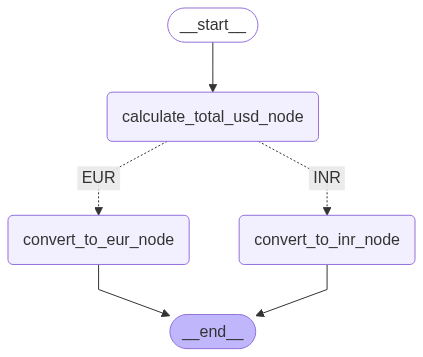

In [22]:
graph = builder.compile()
graph

In [25]:
# data = {"amount_in_usd": 15, "target_currency": "EUR"}
data = {"amount_in_usd": 15, "target_currency": "INR"}

obj = PortfolioState(**data)
obj

PortfolioState(amount_in_usd=15.0, total_usd=0, target_currency='INR', target_currency_amount=0)

In [26]:
graph.invoke(obj)

{'amount_in_usd': 15.0,
 'total_usd': 16.2,
 'target_currency': 'INR',
 'target_currency_amount': 1377.0}